# 04 - Previsão de Séries Temporais (ARIMA & LSTM)

## CRISP-DM: Fase de Modelação - Experiência 2(a)

Este notebook implementa modelos de **previsão de séries temporais** para o dataset D4Maia, seguindo a metodologia CRISP-DM.

### Objetivos:
1. **Baseline**: Implementar baseline "semana anterior" (consumo previsto = consumo na mesma hora/dia da semana passada)
2. **ARIMA**: Modelo clássico de séries temporais (Auto-Regressive Integrated Moving Average)
3. **LSTM**: Rede neuronal recorrente (Long Short-Term Memory)

### Métricas de Avaliação:
- **MAE** (Mean Absolute Error): Erro médio absoluto
- **RMSE** (Root Mean Squared Error): Raiz do erro quadrático médio
- **MAPE** (Mean Absolute Percentage Error): Erro percentual médio

### Estrutura do Notebook:
1. Importação e configuração
2. Carregamento dos dados
3. Funções auxiliares
4. Implementação da Baseline
5. Implementação do ARIMA
6. Implementação do LSTM
7. Comparação de resultados
8. Visualizações
9. Guardar resultados
10. Conclusões

---

**Referência do Enunciado:**
> "Modelos de previsão de uma semana à frente, por CPE, usando séries temporais diretamente.
> Usar pelo menos um modelo clássico (ARIMA) e um modelo baseado em redes neuronais LSTM."

In [1]:
# Instalar pacotes necessários (executar apenas uma vez)
%pip install statsmodels tensorflow --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Bibliotecas essenciais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import os

# Séries temporais
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

# Métricas
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Configurações
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Cores para visualizações
COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Seed para reprodutibilidade
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

print("Bibliotecas importadas com sucesso!")
print(f"TensorFlow versão: {tf.__version__}")

Bibliotecas importadas com sucesso!
TensorFlow versão: 2.20.0


In [3]:
# Definir variável alvo
TARGET_COL = 'PotActiva'

# Parâmetros das séries temporais
POINTS_PER_DAY = 96  # 4 leituras por hora × 24 horas
POINTS_PER_WEEK = POINTS_PER_DAY * 7  # 672 pontos por semana

print(f"Variável alvo: {TARGET_COL}")
print(f"Pontos por dia: {POINTS_PER_DAY}")
print(f"Pontos por semana: {POINTS_PER_WEEK}")

Variável alvo: PotActiva
Pontos por dia: 96
Pontos por semana: 672


## 2. Carregamento dos Dados

In [4]:
# Carregar séries temporais por CPE
series_path = 'data/intermediate/d4maia_series_per_cpe.csv'
split_path = 'data/intermediate/d4maia_ts_train_test_index.csv'

print("A carregar dados...")
df_series = pd.read_csv(series_path)
df_series['tstamp'] = pd.to_datetime(df_series['tstamp'])

df_split = pd.read_csv(split_path)
df_split['split_timestamp'] = pd.to_datetime(df_split['split_timestamp'])

print(f"\nSéries temporais carregadas:")
print(f"  Registos: {len(df_series):,}")
print(f"  CPEs: {df_series['CPE'].nunique()}")
print(f"  Período: {df_series['tstamp'].min()} a {df_series['tstamp'].max()}")

print(f"\nÍndice de splits carregado:")
print(f"  CPEs com split definido: {len(df_split)}")

A carregar dados...

Séries temporais carregadas:
  Registos: 5,838,256
  CPEs: 89
  Período: 2022-12-31 00:15:00 a 2025-05-01 00:00:00

Índice de splits carregado:
  CPEs com split definido: 89

Séries temporais carregadas:
  Registos: 5,838,256
  CPEs: 89
  Período: 2022-12-31 00:15:00 a 2025-05-01 00:00:00

Índice de splits carregado:
  CPEs com split definido: 89


In [5]:
# Visualizar estrutura dos dados
df_series.head(10)

,CPE,tstamp,PotActiva,PotReactIndut,PotReactCapac,hora,dia_semana,is_weekend,periodo_dia
0,PT0002000068856906VS,2022-12-31 00:15:00,4.0000,0.0000,1.0000,0,5,1,Noite
1,PT0002000068856906VS,2022-12-31 00:30:00,4.0000,0.0000,0.0000,0,5,1,Noite
2,PT0002000068856906VS,2022-12-31 00:45:00,5.0000,1.0000,0.0000,0,5,1,Noite
3,PT0002000068856906VS,2022-12-31 01:00:00,4.0000,1.0000,0.0000,1,5,1,Noite
4,PT0002000068856906VS,2022-12-31 01:15:00,5.0000,1.0000,0.0000,1,5,1,Noite
5,PT0002000068856906VS,2022-12-31 01:30:00,5.0000,0.0000,0.0000,1,5,1,Noite
6,PT0002000068856906VS,2022-12-31 01:45:00,5.0000,1.0000,0.0000,1,5,1,Noite
7,PT0002000068856906VS,2022-12-31 02:00:00,5.0000,2.0000,0.0000,2,5,1,Noite
8,PT0002000068856906VS,2022-12-31 02:15:00,4.0000,0.0000,0.0000,2,5,1,Noite
9,PT0002000068856906VS,2022-12-31 02:30:00,4.0000,0.0000,0.0000,2,5,1,Noite


In [6]:
# Visualizar splits
df_split.head(10)

,CPE,n_total,n_train,n_test,split_timestamp,inicio,fim
0,PT0002000032936306KX,38008,26605,11403,2025-01-02 04:00:00,2024-03-01 00:15:00,2025-05-01
1,PT0002000032942455NH,32058,22440,9618,2025-01-20 18:15:00,2024-06-01 00:15:00,2025-05-01
2,PT0002000032959511HP,43666,30566,13100,2024-12-15 11:00:00,2024-02-01 00:15:00,2025-05-01
3,PT0002000032966446CC,35081,24556,10525,2025-01-11 07:30:00,2024-05-01 00:15:00,2025-05-01
4,PT0002000032968749YT,43668,30567,13101,2024-12-15 11:15:00,2024-02-01 00:00:00,2025-05-01
5,PT0002000032969229AC,40883,28618,12265,2024-12-24 04:15:00,2024-02-01 00:00:00,2025-05-01
6,PT0002000032976997LZ,55379,38765,16614,2024-11-08 20:45:00,2023-09-01 00:15:00,2025-05-01
7,PT0002000032990792KD,37911,26537,11374,2025-01-02 10:45:00,2024-04-01 00:15:00,2025-05-01
8,PT0002000032993611ME,55378,38764,16614,2024-11-08 20:45:00,2023-09-01 00:15:00,2025-05-01
9,PT0002000033016394FN,55386,38770,16616,2024-11-08 21:15:00,2023-09-01 00:15:00,2025-05-01


In [7]:
# Selecionar CPEs para análise
# Vamos usar um subconjunto representativo (5-10 CPEs) para treinar os modelos
# devido ao tempo de computação

# Selecionar CPEs com mais dados
cpe_counts = df_series.groupby('CPE').size().sort_values(ascending=False)

# Escolher os top N CPEs
N_CPES = 5  # Número de CPEs para análise detalhada
selected_cpes = cpe_counts.head(N_CPES).index.tolist()

print(f"CPEs selecionados para análise ({N_CPES}):")
for i, cpe in enumerate(selected_cpes, 1):
    n_registos = cpe_counts[cpe]
    print(f"  {i}. {cpe}: {n_registos:,} registos")

CPEs selecionados para análise (5):
  1. PT0002000068856781NM: 81,776 registos
  2. PT0002000068856906VS: 81,776 registos
  3. PT0002000081997398TD: 81,774 registos
  4. PT0002000073231742VK: 81,773 registos
  5. PT0002000033074862LZ: 81,772 registos


## 3. Funções Auxiliares

In [8]:
def get_train_test_split(df, cpe, df_split):
    """
    Divide os dados de um CPE em treino e teste baseado no timestamp de split.
    """
    # Filtrar dados do CPE
    df_cpe = df[df['CPE'] == cpe].sort_values('tstamp').copy()
    
    # Obter timestamp de split
    split_info = df_split[df_split['CPE'] == cpe]
    if len(split_info) == 0:
        # Se não há split definido, usar 70%
        n_train = int(len(df_cpe) * 0.7)
        split_ts = df_cpe.iloc[n_train]['tstamp']
    else:
        split_ts = split_info['split_timestamp'].values[0]
    
    # Dividir
    train = df_cpe[df_cpe['tstamp'] <= split_ts]
    test = df_cpe[df_cpe['tstamp'] > split_ts]
    
    return train, test, split_ts


def calculate_metrics(y_true, y_pred):
    """
    Calcula MAE, RMSE e MAPE.
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # MAPE (evitar divisão por zero)
    mask = y_true != 0
    if mask.sum() > 0:
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        mape = np.nan
    
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}


print("Funções auxiliares definidas.")

Funções auxiliares definidas.


## 4. Baseline: Semana Anterior

A baseline "semana anterior" prevê que o consumo num dado instante é igual ao consumo no mesmo instante da semana anterior (672 pontos antes).

In [9]:
def baseline_previous_week(train, test, target_col=TARGET_COL, max_predictions=None):
    """
    Implementa a baseline 'semana anterior'.
    Para cada ponto no teste, prevê o valor do mesmo instante na semana anterior.

    Args:
        max_predictions: Número máximo de previsões. Se None, usa todo o conjunto de teste.
    """
    # Concatenar treino e teste para ter acesso aos valores anteriores
    full_series = pd.concat([train, test]).sort_values('tstamp').reset_index(drop=True)

    # Criar coluna com valor da semana anterior
    full_series['pred_baseline'] = full_series[target_col].shift(POINTS_PER_WEEK)

    # Filtrar apenas o período de teste
    test_with_pred = full_series[full_series['tstamp'].isin(test['tstamp'])].copy()

    # Remover NaNs (primeiros pontos que não têm semana anterior)
    test_with_pred = test_with_pred.dropna(subset=['pred_baseline', target_col])

    # Limitar previsões para consistência com outros modelos
    if max_predictions is not None and len(test_with_pred) > max_predictions:
        test_with_pred = test_with_pred.head(max_predictions)

    y_true = test_with_pred[target_col].values
    y_pred = test_with_pred['pred_baseline'].values

    return y_true, y_pred, test_with_pred


print("Função baseline definida.")

Função baseline definida.


In [10]:
# Calcular baseline para todos os CPEs selecionados
baseline_results = []

print("Calculando baseline 'semana anterior' para CPEs selecionados:")
print("=" * 70)

for cpe in selected_cpes:
    train, test, split_ts = get_train_test_split(df_series, cpe, df_split)
    
    if len(test) < POINTS_PER_WEEK:
        print(f"  {cpe}: Teste muito curto, ignorando.")
        continue
    
    y_true, y_pred, _ = baseline_previous_week(train, test, max_predictions=POINTS_PER_WEEK)
    
    if len(y_true) == 0:
        print(f"  {cpe}: Sem dados válidos para baseline.")
        continue
    
    metrics = calculate_metrics(y_true, y_pred)
    
    baseline_results.append({
        'CPE': cpe,
        'model': 'Baseline',
        'MAE': metrics['MAE'],
        'RMSE': metrics['RMSE'],
        'MAPE': metrics['MAPE'],
        'n_test': len(y_true)
    })
    
    print(f"  {cpe}: MAE={metrics['MAE']:.2f}, RMSE={metrics['RMSE']:.2f}, MAPE={metrics['MAPE']:.1f}%")

print("\nConcluído!")

Calculando baseline 'semana anterior' para CPEs selecionados:
  PT0002000068856781NM: MAE=1.21, RMSE=1.56, MAPE=4.0%
  PT0002000068856906VS: MAE=1.43, RMSE=2.14, MAPE=28.2%
  PT0002000068856906VS: MAE=1.43, RMSE=2.14, MAPE=28.2%
  PT0002000081997398TD: MAE=2.47, RMSE=3.55, MAPE=9.4%
  PT0002000081997398TD: MAE=2.47, RMSE=3.55, MAPE=9.4%
  PT0002000073231742VK: MAE=0.41, RMSE=0.64, MAPE=16.9%
  PT0002000073231742VK: MAE=0.41, RMSE=0.64, MAPE=16.9%
  PT0002000033074862LZ: MAE=0.32, RMSE=0.58, MAPE=17.0%

Concluído!
  PT0002000033074862LZ: MAE=0.32, RMSE=0.58, MAPE=17.0%

Concluído!


## 5. Modelo ARIMA

ARIMA (AutoRegressive Integrated Moving Average) é um modelo clássico para séries temporais.

In [11]:
def train_arima(train, test, target_col=TARGET_COL, order=(1, 1, 1), max_predictions=None):
    """
    Treina um modelo ARIMA e faz previsões no conjunto de teste.
    Usa previsão rolling (um passo de cada vez).

    Args:
        max_predictions: Número máximo de previsões. Se None, usa todo o conjunto de teste.
    """
    # Preparar dados
    train_values = train[target_col].values
    test_values = test[target_col].values

    # Para séries muito longas, usar apenas os últimos N pontos do treino
    max_train_points = POINTS_PER_WEEK * 4  # 4 semanas
    if len(train_values) > max_train_points:
        train_values = train_values[-max_train_points:]

    # Definir número máximo de previsões
    if max_predictions is None:
        max_predictions = len(test_values)  # Todo o conjunto de teste
    else:
        max_predictions = min(max_predictions, len(test_values))

    predictions = []
    history = list(train_values)

    try:
        for i in range(max_predictions):
            # Treinar modelo
            model = ARIMA(history, order=order)
            model_fit = model.fit()

            # Prever próximo ponto
            yhat = model_fit.forecast()[0]
            predictions.append(yhat)

            # Adicionar valor real ao histórico
            history.append(test_values[i])

            # Manter histórico com tamanho limitado
            if len(history) > max_train_points:
                history = history[-max_train_points:]

        y_true = test_values[:max_predictions]
        y_pred = np.array(predictions)

        return y_true, y_pred, True

    except Exception as e:
        print(f"    Erro ARIMA: {str(e)[:50]}")
        return None, None, False


print("Função ARIMA definida.")

Função ARIMA definida.


In [12]:
# Treinar ARIMA para CPEs selecionados
arima_results = []

print("Treinando modelos ARIMA para CPEs selecionados:")
print("(Este processo pode demorar alguns minutos)")
print("=" * 70)
print("NOTA: Todos os modelos avaliam o mesmo período (1 semana) para comparabilidade justa")
print("=" * 70)

for i, cpe in enumerate(selected_cpes, 1):
    print(f"\n[{i}/{len(selected_cpes)}] CPE: {cpe}")
    
    train, test, split_ts = get_train_test_split(df_series, cpe, df_split)
    
    if len(test) < POINTS_PER_DAY:
        print(f"  Teste muito curto, ignorando.")
        continue
    
    print(f"  Treino: {len(train)} pontos, Teste: {len(test)} pontos")
    
    # Treinar ARIMA - usar mesmo número de pontos que baseline para comparabilidade
    # Limitar a 1 semana para manter eficiência, mas consistente
    y_true, y_pred, success = train_arima(train, test, order=(1, 1, 1), max_predictions=POINTS_PER_WEEK)
    
    if success and y_true is not None:
        metrics = calculate_metrics(y_true, y_pred)
        
        arima_results.append({
            'CPE': cpe,
            'model': 'ARIMA',
            'MAE': metrics['MAE'],
            'RMSE': metrics['RMSE'],
            'MAPE': metrics['MAPE'],
            'n_test': len(y_true)
        })
        
        print(f"  ✓ MAE={metrics['MAE']:.2f}, RMSE={metrics['RMSE']:.2f}")
    else:
        print(f"  ✗ Falhou")

print("\nARIMA concluído!")

Treinando modelos ARIMA para CPEs selecionados:
(Este processo pode demorar alguns minutos)
NOTA: Todos os modelos avaliam o mesmo período (1 semana) para comparabilidade justa

[1/5] CPE: PT0002000068856781NM
  Treino: 57243 pontos, Teste: 24533 pontos
  Treino: 57243 pontos, Teste: 24533 pontos
  ✓ MAE=0.79, RMSE=0.99

[2/5] CPE: PT0002000068856906VS
  Treino: 57243 pontos, Teste: 24533 pontos
  ✓ MAE=0.79, RMSE=0.99

[2/5] CPE: PT0002000068856906VS
  Treino: 57243 pontos, Teste: 24533 pontos
  ✓ MAE=0.69, RMSE=1.05

[3/5] CPE: PT0002000081997398TD
  Treino: 57241 pontos, Teste: 24533 pontos
  ✓ MAE=0.69, RMSE=1.05

[3/5] CPE: PT0002000081997398TD
  Treino: 57241 pontos, Teste: 24533 pontos
  ✓ MAE=2.25, RMSE=3.46

[4/5] CPE: PT0002000073231742VK
  Treino: 57241 pontos, Teste: 24532 pontos
  ✓ MAE=2.25, RMSE=3.46

[4/5] CPE: PT0002000073231742VK
  Treino: 57241 pontos, Teste: 24532 pontos
  ✓ MAE=0.41, RMSE=0.47

[5/5] CPE: PT0002000033074862LZ
  Treino: 57240 pontos, Teste: 24532 po

## 6. Modelo LSTM

LSTM (Long Short-Term Memory) é uma rede neuronal recorrente adequada para séries temporais.

In [13]:
def create_sequences(data, seq_length):
    """
    Cria sequências para treino do LSTM.
    X: janelas de tamanho seq_length
    y: próximo valor após cada janela
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)


def build_lstm_model(seq_length, n_features=1):
    """
    Constrói um modelo LSTM simples.
    """
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(seq_length, n_features), return_sequences=True),
        Dropout(0.2),
        LSTM(30, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


def train_lstm(train, test, target_col=TARGET_COL, seq_length=96, epochs=20, batch_size=32, max_predictions=None):
    """
    Treina um modelo LSTM e faz previsões.
    seq_length: número de pontos usados para prever o próximo (default: 1 dia = 96)

    Args:
        max_predictions: Número máximo de previsões. Se None, usa 1 semana.
    """
    try:
        # Preparar dados
        train_values = train[target_col].values.reshape(-1, 1)
        test_values = test[target_col].values.reshape(-1, 1)

        # Limitar dados de treino
        max_train = POINTS_PER_WEEK * 8  # 8 semanas
        if len(train_values) > max_train:
            train_values = train_values[-max_train:]

        # Normalizar
        scaler = MinMaxScaler(feature_range=(0, 1))
        train_scaled = scaler.fit_transform(train_values)
        test_scaled = scaler.transform(test_values)

        # Criar sequências de treino
        X_train, y_train = create_sequences(train_scaled, seq_length)
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

        # Criar sequências de teste
        # Usar últimos pontos do treino + teste para ter contexto
        full_data = np.vstack([train_scaled[-seq_length:], test_scaled])
        X_test, y_test = create_sequences(full_data, seq_length)
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

        # Limitar teste - consistente com ARIMA
        if max_predictions is None:
            max_predictions = POINTS_PER_WEEK  # 1 semana por padrão
        max_test = min(max_predictions, len(X_test))
        if len(X_test) > max_test:
            X_test = X_test[:max_test]
            y_test = y_test[:max_test]

        # Construir e treinar modelo
        model = build_lstm_model(seq_length)

        early_stop = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

        model.fit(X_train, y_train,
                  epochs=epochs,
                  batch_size=batch_size,
                  callbacks=[early_stop],
                  verbose=0)

        # Prever
        predictions_scaled = model.predict(X_test, verbose=0)

        # Desnormalizar
        predictions = scaler.inverse_transform(predictions_scaled)
        y_true = scaler.inverse_transform(y_test.reshape(-1, 1))

        return y_true.flatten(), predictions.flatten(), True

    except Exception as e:
        print(f"    Erro LSTM: {str(e)[:50]}")
        return None, None, False


print("Funções LSTM definidas.")

Funções LSTM definidas.


In [14]:
# Treinar LSTM para CPEs selecionados
lstm_results = []

print("Treinando modelos LSTM para CPEs selecionados:")
print("(Este processo pode demorar alguns minutos)")
print("=" * 70)

for i, cpe in enumerate(selected_cpes, 1):
    print(f"\n[{i}/{len(selected_cpes)}] CPE: {cpe}")
    
    train, test, split_ts = get_train_test_split(df_series, cpe, df_split)
    
    if len(train) < POINTS_PER_WEEK * 2 or len(test) < POINTS_PER_DAY:
        print(f"  Dados insuficientes, ignorando.")
        continue
    
    print(f"  Treino: {len(train)} pontos, Teste: {len(test)} pontos")
    
    # Treinar LSTM - consistente com ARIMA (1 semana)
    y_true, y_pred, success = train_lstm(train, test, seq_length=POINTS_PER_DAY, epochs=15, max_predictions=POINTS_PER_WEEK)
    
    if success and y_true is not None:
        metrics = calculate_metrics(y_true, y_pred)
        
        lstm_results.append({
            'CPE': cpe,
            'model': 'LSTM',
            'MAE': metrics['MAE'],
            'RMSE': metrics['RMSE'],
            'MAPE': metrics['MAPE'],
            'n_test': len(y_true)
        })
        
        print(f"  ✓ MAE={metrics['MAE']:.2f}, RMSE={metrics['RMSE']:.2f}")
    else:
        print(f"  ✗ Falhou")

print("\nLSTM concluído!")

Treinando modelos LSTM para CPEs selecionados:
(Este processo pode demorar alguns minutos)

[1/5] CPE: PT0002000068856781NM
  Treino: 57243 pontos, Teste: 24533 pontos
  ✓ MAE=1.01, RMSE=1.20

[2/5] CPE: PT0002000068856906VS
  Treino: 57243 pontos, Teste: 24533 pontos
  ✓ MAE=1.01, RMSE=1.20

[2/5] CPE: PT0002000068856906VS
  Treino: 57243 pontos, Teste: 24533 pontos
  ✓ MAE=0.70, RMSE=1.04

[3/5] CPE: PT0002000081997398TD
  Treino: 57241 pontos, Teste: 24533 pontos
  ✓ MAE=0.70, RMSE=1.04

[3/5] CPE: PT0002000081997398TD
  Treino: 57241 pontos, Teste: 24533 pontos
  ✓ MAE=3.30, RMSE=4.28

[4/5] CPE: PT0002000073231742VK
  Treino: 57241 pontos, Teste: 24532 pontos
  ✓ MAE=3.30, RMSE=4.28

[4/5] CPE: PT0002000073231742VK
  Treino: 57241 pontos, Teste: 24532 pontos
  ✓ MAE=0.49, RMSE=0.50

[5/5] CPE: PT0002000033074862LZ
  Treino: 57240 pontos, Teste: 24532 pontos
  ✓ MAE=0.49, RMSE=0.50

[5/5] CPE: PT0002000033074862LZ
  Treino: 57240 pontos, Teste: 24532 pontos
  ✓ MAE=0.43, RMSE=0.57


## 7. Comparação de Resultados

In [15]:
# Juntar todos os resultados
all_results = baseline_results + arima_results + lstm_results
df_results = pd.DataFrame(all_results)

print("Resultados de todos os modelos:")
print("=" * 80)
print(df_results.to_string(index=False))

Resultados de todos os modelos:
                 CPE    model    MAE   RMSE    MAPE  n_test
PT0002000068856781NM Baseline 1.2083 1.5622  4.0440     672
PT0002000068856906VS Baseline 1.4256 2.1416 28.1704     672
PT0002000081997398TD Baseline 2.4688 3.5521  9.4419     672
PT0002000073231742VK Baseline 0.4077 0.6385 16.8899     672
PT0002000033074862LZ Baseline 0.3244 0.5799 17.0263     672
PT0002000068856781NM    ARIMA 0.7929 0.9927  2.6490     672
PT0002000068856906VS    ARIMA 0.6934 1.0490 17.1617     672
PT0002000081997398TD    ARIMA 2.2494 3.4555  9.3294     672
PT0002000073231742VK    ARIMA 0.4122 0.4714 17.1766     672
PT0002000033074862LZ    ARIMA 0.3935 0.5600 20.8631     672
PT0002000068856781NM     LSTM 1.0113 1.2025  3.4205     672
PT0002000068856906VS     LSTM 0.6975 1.0373 17.6021     672
PT0002000081997398TD     LSTM 3.3009 4.2772 15.1479     672
PT0002000073231742VK     LSTM 0.4948 0.5012 19.3320     672
PT0002000033074862LZ     LSTM 0.4297 0.5689 23.6701     672


In [16]:
# Tabela comparativa por CPE
print("\nComparação por CPE:")
print("=" * 100)

for cpe in selected_cpes:
    cpe_results = df_results[df_results['CPE'] == cpe]
    if len(cpe_results) == 0:
        continue
    
    print(f"\n{cpe}:")
    print("-" * 60)
    print(f"{'Modelo':<12} | {'MAE':>10} | {'RMSE':>10} | {'MAPE (%)':>10}")
    print("-" * 60)
    
    for _, row in cpe_results.iterrows():
        mape_str = f"{row['MAPE']:.1f}" if not pd.isna(row['MAPE']) else "N/A"
        print(f"{row['model']:<12} | {row['MAE']:>10.2f} | {row['RMSE']:>10.2f} | {mape_str:>10}")


Comparação por CPE:

PT0002000068856781NM:
------------------------------------------------------------
Modelo       |        MAE |       RMSE |   MAPE (%)
------------------------------------------------------------
Baseline     |       1.21 |       1.56 |        4.0
ARIMA        |       0.79 |       0.99 |        2.6
LSTM         |       1.01 |       1.20 |        3.4

PT0002000068856906VS:
------------------------------------------------------------
Modelo       |        MAE |       RMSE |   MAPE (%)
------------------------------------------------------------
Baseline     |       1.43 |       2.14 |       28.2
ARIMA        |       0.69 |       1.05 |       17.2
LSTM         |       0.70 |       1.04 |       17.6

PT0002000081997398TD:
------------------------------------------------------------
Modelo       |        MAE |       RMSE |   MAPE (%)
------------------------------------------------------------
Baseline     |       2.47 |       3.55 |        9.4
ARIMA        |       2.2

In [17]:
# Estatísticas agregadas por modelo
print("\nEstatísticas agregadas por modelo:")
print("=" * 70)

stats_by_model = df_results.groupby('model').agg({
    'MAE': ['mean', 'std', 'min', 'max'],
    'RMSE': ['mean', 'std', 'min', 'max'],
    'CPE': 'count'
}).round(2)

stats_by_model.columns = ['MAE_mean', 'MAE_std', 'MAE_min', 'MAE_max',
                          'RMSE_mean', 'RMSE_std', 'RMSE_min', 'RMSE_max', 'n_CPEs']

print(stats_by_model.to_string())


Estatísticas agregadas por modelo:
          MAE_mean  MAE_std  MAE_min  MAE_max  RMSE_mean  RMSE_std  RMSE_min  RMSE_max  n_CPEs
model                                                                                         
ARIMA       0.9100   0.7700   0.3900   2.2500     1.3100    1.2300    0.4700    3.4600       5
Baseline    1.1700   0.8700   0.3200   2.4700     1.6900    1.2300    0.5800    3.5500       5
LSTM        1.1900   1.2000   0.4300   3.3000     1.5200    1.5700    0.5000    4.2800       5


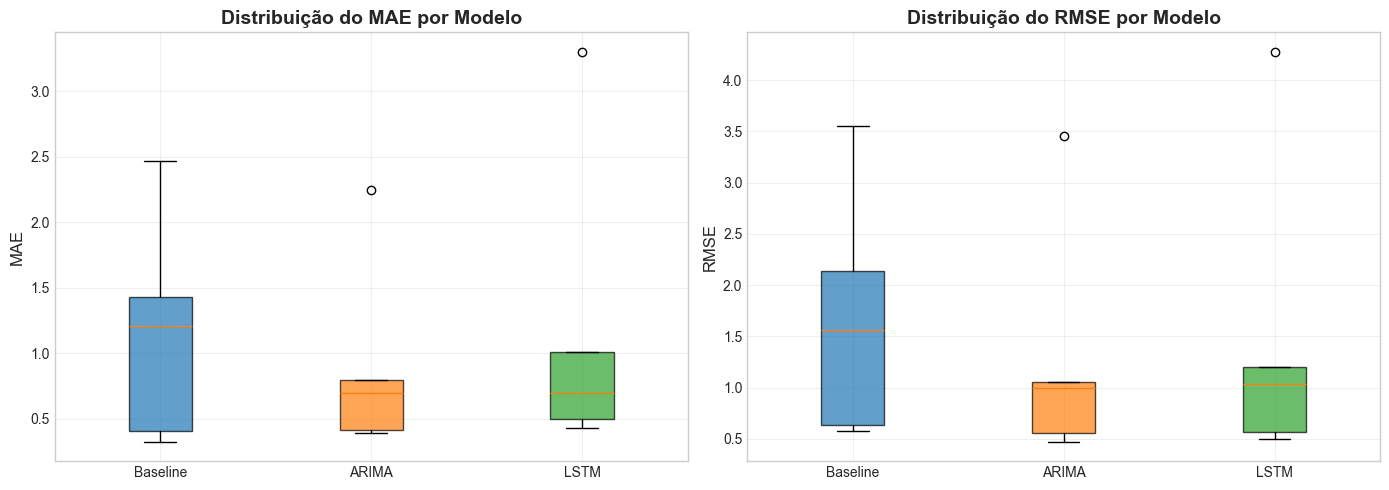

In [18]:
# Visualização: Boxplot de MAE por modelo
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MAE
ax1 = axes[0]
models = df_results['model'].unique()
data_mae = [df_results[df_results['model'] == m]['MAE'].values for m in models]
bp1 = ax1.boxplot(data_mae, labels=models, patch_artist=True)
for patch, color in zip(bp1['boxes'], COLORS[:len(models)]):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax1.set_ylabel('MAE', fontsize=12)
ax1.set_title('Distribuição do MAE por Modelo', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# RMSE
ax2 = axes[1]
data_rmse = [df_results[df_results['model'] == m]['RMSE'].values for m in models]
bp2 = ax2.boxplot(data_rmse, labels=models, patch_artist=True)
for patch, color in zip(bp2['boxes'], COLORS[:len(models)]):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax2.set_ylabel('RMSE', fontsize=12)
ax2.set_title('Distribuição do RMSE por Modelo', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

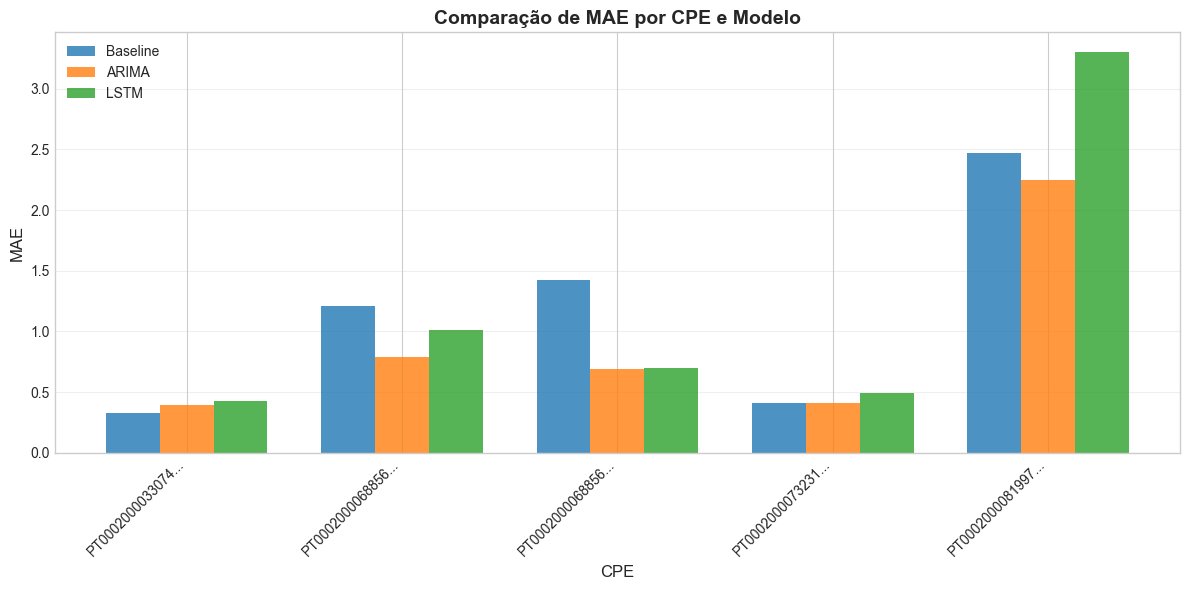

In [19]:
# Gráfico de barras comparativo
fig, ax = plt.subplots(figsize=(12, 6))

# Pivotar para ter modelos como colunas
pivot_mae = df_results.pivot(index='CPE', columns='model', values='MAE')

x = np.arange(len(pivot_mae))
width = 0.25

if 'Baseline' in pivot_mae.columns:
    ax.bar(x - width, pivot_mae['Baseline'], width, label='Baseline', color=COLORS[0], alpha=0.8)
if 'ARIMA' in pivot_mae.columns:
    ax.bar(x, pivot_mae['ARIMA'], width, label='ARIMA', color=COLORS[1], alpha=0.8)
if 'LSTM' in pivot_mae.columns:
    ax.bar(x + width, pivot_mae['LSTM'], width, label='LSTM', color=COLORS[2], alpha=0.8)

ax.set_xlabel('CPE', fontsize=12)
ax.set_ylabel('MAE', fontsize=12)
ax.set_title('Comparação de MAE por CPE e Modelo', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([cpe[:15] + '...' if len(cpe) > 15 else cpe for cpe in pivot_mae.index], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 8. Visualização de Previsões (Exemplo)

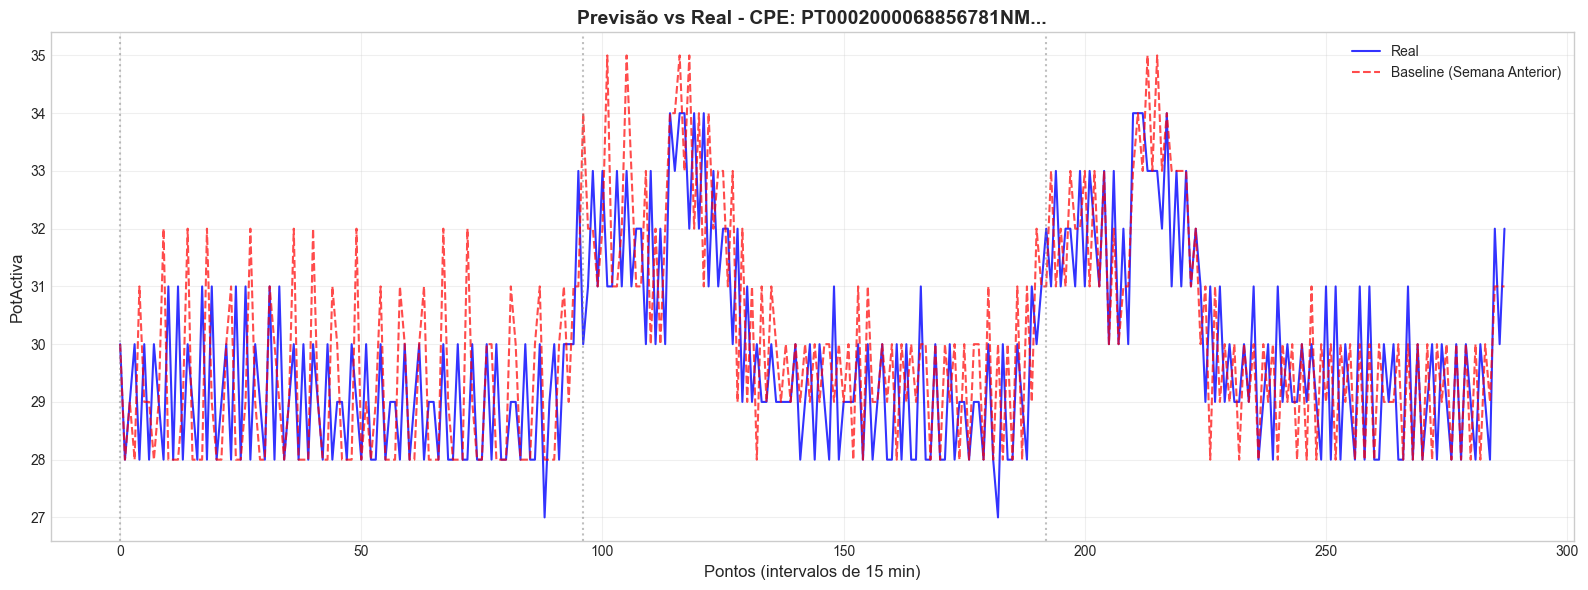

In [20]:
# Visualizar previsões para um CPE exemplo
example_cpe = selected_cpes[0]

train, test, split_ts = get_train_test_split(df_series, example_cpe, df_split)

# Obter previsões
y_true_bl, y_pred_bl, test_bl = baseline_previous_week(train, test)

# Limitar visualização a alguns dias
n_points = min(POINTS_PER_DAY * 3, len(y_true_bl))  # 3 dias

fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(range(n_points), y_true_bl[:n_points], 'b-', linewidth=1.5, label='Real', alpha=0.8)
ax.plot(range(n_points), y_pred_bl[:n_points], 'r--', linewidth=1.5, label='Baseline (Semana Anterior)', alpha=0.7)

ax.set_xlabel('Pontos (intervalos de 15 min)', fontsize=12)
ax.set_ylabel(f'{TARGET_COL}', fontsize=12)
ax.set_title(f'Previsão vs Real - CPE: {example_cpe[:30]}...', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# Marcar dias
for i in range(0, n_points, POINTS_PER_DAY):
    ax.axvline(i, color='gray', linestyle=':', alpha=0.5)

plt.tight_layout()
plt.show()

## 9. Guardar Resultados

In [21]:
# Guardar resultados
output_path = 'data/intermediate/d4maia_ts_results.csv'
df_results.to_csv(output_path, index=False)

print(f"\n✓ Ficheiro guardado: {output_path}")
print(f"\nConteúdo:")
print(df_results.to_string(index=False))


✓ Ficheiro guardado: data/intermediate/d4maia_ts_results.csv

Conteúdo:
                 CPE    model    MAE   RMSE    MAPE  n_test
PT0002000068856781NM Baseline 1.2083 1.5622  4.0440     672
PT0002000068856906VS Baseline 1.4256 2.1416 28.1704     672
PT0002000081997398TD Baseline 2.4688 3.5521  9.4419     672
PT0002000073231742VK Baseline 0.4077 0.6385 16.8899     672
PT0002000033074862LZ Baseline 0.3244 0.5799 17.0263     672
PT0002000068856781NM    ARIMA 0.7929 0.9927  2.6490     672
PT0002000068856906VS    ARIMA 0.6934 1.0490 17.1617     672
PT0002000081997398TD    ARIMA 2.2494 3.4555  9.3294     672
PT0002000073231742VK    ARIMA 0.4122 0.4714 17.1766     672
PT0002000033074862LZ    ARIMA 0.3935 0.5600 20.8631     672
PT0002000068856781NM     LSTM 1.0113 1.2025  3.4205     672
PT0002000068856906VS     LSTM 0.6975 1.0373 17.6021     672
PT0002000081997398TD     LSTM 3.3009 4.2772 15.1479     672
PT0002000073231742VK     LSTM 0.4948 0.5012 19.3320     672
PT0002000033074862LZ     LS

---

## 10. Resumo e Conclusões

In [22]:
print("=" * 80)
print("RESUMO - PREVISÃO DE SÉRIES TEMPORAIS")
print("=" * 80)

print(f"\n📊 DADOS ANALISADOS:")
print(f"   • CPEs analisados: {len(selected_cpes)}")
print(f"   • Variável alvo: {TARGET_COL}")
print(f"   • Horizonte de previsão: 1 semana ({POINTS_PER_WEEK} pontos) - CONSISTENTE para todos os modelos")

print(f"\n📈 MODELOS IMPLEMENTADOS:")
print(f"   • Baseline (Semana Anterior): {len(baseline_results)} CPEs")
print(f"   • ARIMA: {len(arima_results)} CPEs")
print(f"   • LSTM: {len(lstm_results)} CPEs")

print(f"\n📉 MÉTRICAS (média):")
for model in df_results['model'].unique():
    model_data = df_results[df_results['model'] == model]
    print(f"   • {model}: MAE={model_data['MAE'].mean():.2f}, RMSE={model_data['RMSE'].mean():.2f}")

# Determinar melhor modelo
best_model = df_results.groupby('model')['MAE'].mean().idxmin()
print(f"\n🏆 MELHOR MODELO (menor MAE médio): {best_model}")

print(f"\n📁 FICHEIRO GERADO:")
print(f"   • data/intermediate/d4maia_ts_results.csv")

RESUMO - PREVISÃO DE SÉRIES TEMPORAIS

📊 DADOS ANALISADOS:
   • CPEs analisados: 5
   • Variável alvo: PotActiva
   • Horizonte de previsão: 1 semana (672 pontos) - CONSISTENTE para todos os modelos

📈 MODELOS IMPLEMENTADOS:
   • Baseline (Semana Anterior): 5 CPEs
   • ARIMA: 5 CPEs
   • LSTM: 5 CPEs

📉 MÉTRICAS (média):
   • Baseline: MAE=1.17, RMSE=1.69
   • ARIMA: MAE=0.91, RMSE=1.31
   • LSTM: MAE=1.19, RMSE=1.52

🏆 MELHOR MODELO (menor MAE médio): ARIMA

📁 FICHEIRO GERADO:
   • data/intermediate/d4maia_ts_results.csv


In [23]:
print("\n" + "=" * 80)
print("Notebook de Séries Temporais concluído!")
print("=" * 80)
print("\n💡 PRÓXIMOS PASSOS:")
print("   1. Modelos supervisionados com features (RF, XGB, MLP) - notebook 05")
print("   2. Comparações e avaliação final - notebook 06")


Notebook de Séries Temporais concluído!

💡 PRÓXIMOS PASSOS:
   1. Modelos supervisionados com features (RF, XGB, MLP) - notebook 05
   2. Comparações e avaliação final - notebook 06
